## 2 layer climate model, Ali Duffey 11/01/2022

#### note that forcing files and temperature observations are required to run

In [2]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#read in historic observations
HadCRUT_Historic_Temp = pd.read_csv("HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv")

#read in forcing files for SSPs
F_SSP119 = pd.read_csv("ssp_erf-master\SSPs\ERF_ssp119_1750-2500.csv")[["year", "total"]]
F_SSP245 = pd.read_csv("ssp_erf-master\SSPs\ERF_ssp245_1750-2500.csv")[["year", "total"]]
F_SSP370 = pd.read_csv("ssp_erf-master\SSPs\ERF_ssp370_1750-2500.csv")[["year", "total"]]
F_SSP585 = pd.read_csv("ssp_erf-master\SSPs\ERF_ssp585_1750-2500.csv")[["year","total"]]
F_No_Anthro_Signal = pd.read_csv("ssp_erf-master\SSPs\ERF_ssp119_1750-2500.csv")[["year","total_natural"]].rename({"total_natural":"total"}, axis=1)
F_585_Half_Pinatubo_SRM = pd.read_csv("ssp_erf-master\SSPs\ERF_halfPinatubo_1750-2500.csv")[["year","total"]]
F_585_Double_Pinatubo_SRM = pd.read_csv("ssp_erf-master\SSPs\ERF_doublePinatubo_1750-2500.csv")[["year","total"]]
F_245_One_Pinatubo_SRM = pd.read_csv("ssp_erf-master\SSPs\ERF_ssp245OnePinatubo_1750-2500.csv")[["year","total"]]

F_SSP245_Volcanic = pd.read_csv("ssp_erf-master\SSPs\ERF_ssp245_1750-2500.csv")[["year", "volcanic"]]

#### the following cell defines the scenarios for which temperature is calculated, the order of forcing scenarios must match in both vectors

In [3]:
# "scenarios" contains user defined names, to label output graphs
scenarios = ["SSP119", "SSP245", "SSP370", "SSP585","No_Anthro_Signal", "585_Half_Pinatubo_SRM", "585_Two_Pinatubo_SRM", "F_245_One_Pinatubo_SRM"]
# "Forcings" is a list containing all input forcing arrays to be run
Forcings = [F_SSP119, F_SSP245, F_SSP370, F_SSP585, F_No_Anthro_Signal, F_585_Half_Pinatubo_SRM, F_585_Double_Pinatubo_SRM, F_245_One_Pinatubo_SRM]

#### the following cell contains all required user input parameters

In [4]:
#define key parameters
Density_sea_water = 1027 #kg/m3
Specific_Heat_Capacity_Water = 4218 #J/K/kg 
Height_Upper_Layer = 100 #m
Height_Deep_Layer = 900 #m
Alpha = 1.16 #W/m2/K
Kappa_Cm2_s = 1 #Cm2/s
T_Upper_Init = HadCRUT_Historic_Temp["Anomaly (deg C)"][0]
T_Deep_Init = HadCRUT_Historic_Temp["Anomaly (deg C)"][0]
Seconds_in_year = 3.154*(10**7)
cm2_to_m2_conversion = 0.0001

#define user inputs
start_year = 1850
end_year = 2100

#define working parameters
Capacity_Upper = Density_sea_water*Specific_Heat_Capacity_Water*Height_Upper_Layer
Capacity_Deep = Density_sea_water*Specific_Heat_Capacity_Water*Height_Deep_Layer
Capacity_Upper_Inv = 1/Capacity_Upper
Capacity_Deep_Inv = 1/Capacity_Deep
Kappa_m2_year = Kappa_Cm2_s*cm2_to_m2_conversion*Seconds_in_year
Alpha_y = Alpha*Seconds_in_year
Gamma = 2*Kappa_m2_year*Specific_Heat_Capacity_Water*Density_sea_water/(Height_Upper_Layer + Height_Deep_Layer)

#### no further user input required, the next cell constructs model objects and runs model

In [79]:
#define vectors to run in model
time = np.arange(start_year, end_year)

T_Upper = pd.DataFrame(data = np.zeros((time.size+1, len(scenarios))), columns = scenarios)
T_Deep = pd.DataFrame(data = np.zeros((time.size+1, len(scenarios))), columns = scenarios)
T_Upper.iloc[0] = T_Upper_Init
T_Deep.iloc[0] = T_Deep_Init

#define/read in forcing vector, F
Forcings_df = pd.DataFrame()
for i,j in zip(scenarios, Forcings):
    Forcings_df[i] = j["total"]
Forcings_df["Year"] = F_SSP119["year"]
F = Forcings_df.loc[Forcings_df['Year'].isin(time)]

#define the rates of change of Tu and Td as "functions"
def RateOfChangeOfT_Upper(F, T_Upper_i, T_Deep_i):
    RateOfChangeOfT_Upper = Capacity_Upper_Inv*(F*Seconds_in_year - Alpha_y*T_Upper_i - Gamma*(T_Upper_i-T_Deep_i))
    return RateOfChangeOfT_Upper

def RateOfChangeOfT_Deep(T_Upper_i, T_Deep_i):
    RateOfChangeOfT_Deep = Capacity_Deep_Inv*Gamma*(T_Upper_i-T_Deep_i)
    return RateOfChangeOfT_Deep

#define index which will run through timesteps:
i = 0
j = 0

#calculate temperature at each value of time
for x in time[0:(time.size-1)]:
    for y in scenarios:
        T_Upper.iloc[i+1, j] = T_Upper.iloc[i, j] + RateOfChangeOfT_Upper(F = F.iloc[i,j], T_Upper_i = T_Upper.iloc[i, j], T_Deep_i = T_Deep.iloc[i, j])
        T_Deep.iloc[i+1] = T_Deep.iloc[i, j] + RateOfChangeOfT_Deep(T_Upper_i = T_Upper.iloc[i, j], T_Deep_i = T_Deep.iloc[i, j])
        j = j+1
    i = i + 1
    j = 0

#### plot results and save combined output file to csv

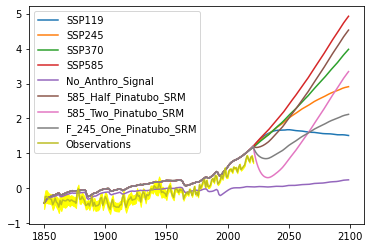

In [81]:
plt.plot(time, T_Upper[0:time.size], label = scenarios)
plt.plot(HadCRUT_Historic_Temp["Time"], HadCRUT_Historic_Temp["Anomaly (deg C)"], label="Observations")
plt.fill_between(HadCRUT_Historic_Temp["Time"], HadCRUT_Historic_Temp["Lower confidence limit (2.5%)"], HadCRUT_Historic_Temp["Upper confidence limit (97.5%)"], color="yellow")
plt.legend()

Output_DF = T_Upper.copy()
Output_DF["HadCRUT_Observations"] = HadCRUT_Historic_Temp["Anomaly (deg C)"]
Output_DF["Year"] = np.arange(start_year, end_year+1)

Output_DF.to_csv("Temperature_Outputs_by_Scenario_Degrees_C_anomaly.csv")

#### unrelated cell to produce a simple figure for pinatubo forcing and temperature response

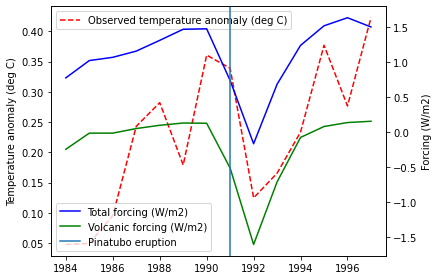

In [83]:
Pinatubo_years = np.arange(1984, 1998)
HadCRUT_Historic_Temp_reduced = HadCRUT_Historic_Temp.loc[HadCRUT_Historic_Temp['Time'].isin(Pinatubo_years)]
F_SSP245_Pinatubo = F_SSP245.loc[F_SSP245['year'].isin(Pinatubo_years)]
F_SSP245_Volcanic_Pinatubo = F_SSP245_Volcanic.loc[F_SSP245_Volcanic['year'].isin(Pinatubo_years)]

fig, ax1 = plt.subplots()
ax1.plot(HadCRUT_Historic_Temp_reduced["Time"], HadCRUT_Historic_Temp_reduced["Anomaly (deg C)"], label="Observed temperature anomaly (deg C)", color='red', ls="--")
plt.legend()
plt.ylabel("Temperature anomaly (deg C)")
ax2 = ax1.twinx()
ax2.plot(F_SSP245_Pinatubo["year"], F_SSP245_Pinatubo["total"], label = "Total forcing (W/m2)", color='blue')
ax2.plot(F_SSP245_Volcanic_Pinatubo["year"], F_SSP245_Volcanic_Pinatubo["volcanic"], label = "Volcanic forcing (W/m2)", color='green')
fig.tight_layout()
plt.legend()
plt.ylabel("Forcing (W/m2)")
plt.axvline(x=1991, label="Pinatubo eruption")
plt.legend()
plt.show()

fig.savefig("Pinatubo_eruption")